In [35]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import LineString, Point
import osmnx  as ox
import networkx as nx
import matplotlib.pyplot as plt

In [36]:
# Kamppi shopping center
origin =  gpd.GeoDataFrame(columns = ['name', 'geometry'], crs = 4326, geometry = 'geometry')
origin.at[0, 'geometry'] = Point(24.933260, 60.169111)
origin.at[0, 'name'] = 'Kamppi'

origin

,name,geometry
0,Kamppi,POINT (24.93326 60.16911)


In [37]:
# Physicum

destination =  gpd.GeoDataFrame(columns = ['name', 'geometry'], crs = 4326, geometry = 'geometry')
destination.at[0, 'geometry'] = Point(24.962608, 60.205301)
destination.at[0, 'name'] = 'Physicum'
destination

,name,geometry
0,Physicum,POINT (24.96261 60.20530)


### 1. Function that gives back a plot with specific OSM network type

In [38]:
def osm_map(origin, destination, network = 'drive'):
    '''origin and destination <geodataframe>, network <str> drive, bike, walk
    return map including origins, destinations, and network
    '''
    
    # creating a frame for fetching OSM data
    combined = origin.append(destination)
    
    convex = combined.unary_union.convex_hull
    
    graph_extent = convex.buffer(0.02)
    
    # fetching graph
    graph = ox.graph_from_polygon(graph_extent, network_type= network)
        
    # Get the GeoDataFrame
    edges = ox.graph_to_gdfs(graph, nodes=False)
    
    plt.style.use('seaborn')
    
    # Plot
    ax = edges.plot(figsize=(14, 8), color='gray', linewidth=0.5, alpha=0.7)
    ax = origin.plot(ax=ax, color='red')
    ax = destination.plot(ax=ax, color='blue')
    
    plt.axis('off')
    
    
    return ax

<AxesSubplot:>

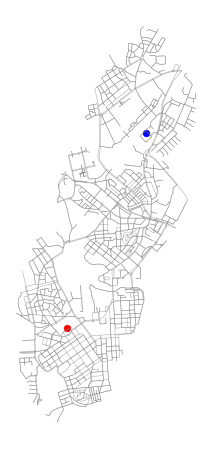

In [39]:
osm_map(origin, destination)
# plt.savefig('drive_network.png')

<AxesSubplot:>

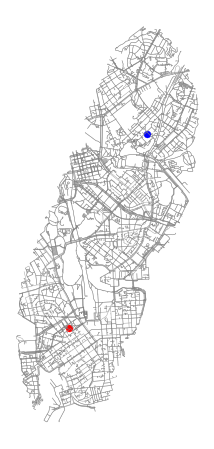

In [40]:
osm_map(origin, destination, 'bike')
# plt.savefig('bike_network.png')

<AxesSubplot:>

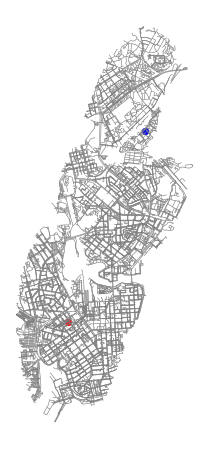

In [41]:
osm_map(origin, destination, 'walk')

### 2. Function that gives back the network as geodataframe

In [42]:
def osm_network(origin, destination, network = 'drive'):
    '''origin and destination <geodataframe>, network <str> drive, bike, or walk
    return network <GeoDataFrame>
    '''
    
    # creating a frame for fetching OSM data
    combined = origin.append(destination)
    
    convex = combined.unary_union.convex_hull
    
    graph_extent = convex.buffer(0.02)
    
    # fetching graph
    graph = ox.graph_from_polygon(graph_extent, network_type= network)
    
    # Get the GeoDataFrame
    edges = ox.graph_to_gdfs(graph, nodes=False)
    
    return edges

In [43]:
drive_gdf = osm_network(origin, destination)
drive_gdf.head()

osmid  oneway   lanes  \
u        v          key                                                     
25216594 1519889325 0     [23717777, 61431074, 607816332]    True       2   
         1372425714 0                            23856784    True       2   
25238874 1372425713 0                [29977177, 30470347]    True       3   
         60469897   0    [73064578, 122961573, 930820886]    True  [1, 2]   
25238944 25216594   0                [372440330, 8135861]    True       2   

                                   name   highway  maxspeed   length  \
u        v          key                                                
25216594 1519889325 0     Porkkalankatu   primary  [40, 50]  322.399   
         1372425714 0    Mechelininkatu   primary        40   40.885   
25238874 1372425713 0    Mechelininkatu   primary        40   16.601   
         60469897   0      Itämerenkatu  tertiary        30  109.773   
25238944 25216594   0               NaN   primary        40   25.190   

                                                                  geometry  \
u        v          key                                                      
25216594 1519889325 0    LINESTRING (24.92106 60.16479, 24.92087 60.164...   
         1372425714 0    LINESTRING (24.92106 60.16479, 24.92095 60.164...   
25238874 1372425713 0    LINESTRING (24.92103 60.16366, 24.92104 60.163...   
         60469897   0    LINESTRING (24.92103 60.16366, 24.92083 60.163...   
25238944 25216594   0    LINESTRING (24.92129 60.16463, 24.92127 60.164...   

                        junction bridge access  ref width est_width tunnel  
u        v          key                                                     
25216594 1519889325 0        NaN    NaN    NaN  NaN   NaN       NaN    NaN  
         1372425714 0        NaN    NaN    NaN  NaN   NaN       NaN    NaN  
25238874 1372425713 0        NaN    NaN    NaN  NaN   NaN       NaN    NaN  
         60469897   0        NaN    NaN    NaN  NaN   NaN       NaN    NaN  
25238944 25216594   0        NaN    NaN    NaN  NaN   NaN       NaN    NaN

In [44]:
type(drive_gdf)

geopandas.geodataframe.GeoDataFrame

In [45]:
# drive_g.to_file('drive.shp')

### 3. Function that gives back the shortest path. It can have many origins and destinations

In [46]:
def shortest_path(origin, destination, network = 'drive'):
    '''origin and destination <geodataframe> crs 4326, network <str> drive, bike, walk
    return shortest path <GeoDataFrame>
    '''
    
    # creating a frame for fetching OSM data
    combined = origin.append(destination)
    
    convex = combined.unary_union.convex_hull
    
    graph_extent = convex.buffer(0.02)
    
    # fetching graph
    graph = ox.graph_from_polygon(graph_extent, network_type= network)
    
    # Reproject the graph
    graph_proj = ox.project_graph(graph)
    
    # Get the GeoDataFrame
    edges = ox.graph_to_gdfs(graph_proj, nodes=False)
    
    # Get CRS info UTM
    CRS = edges.crs
    
    # Reproject all data
    origin_proj = origin.to_crs(crs=CRS)
    destination_proj = destination.to_crs(crs=CRS)
    
    # routes of shortest path
    routes = gpd.GeoDataFrame()
    
    # Get nodes from the graph
    nodes = ox.graph_to_gdfs(graph_proj, edges=False)
    
    # Iterate over origins and destinations
    for oidx, orig in origin_proj.iterrows():
        
        # Find closest node from the graph --> point = (latitude, longitude)
        closest_origin_node = ox.get_nearest_node(G=graph_proj, point=(orig.geometry.y, orig.geometry.x), method='euclidean')
        
        # Iterate over targets
        for tidx, target in destination_proj.iterrows():
            # Find closest node from the graph --> point = (latitude, longitude)
            closest_target_node = ox.get_nearest_node(graph_proj, point=(target.geometry.y, target.geometry.x), method='euclidean')

            # Check if origin and target nodes are the same --> if they are --> skip
            if closest_origin_node == closest_target_node:
                print("Same origin and destination node. Skipping ..")
                continue
            
            # Find the shortest path between the points
            route = nx.shortest_path(graph_proj, 
                                     source=closest_origin_node, 
                                     target=closest_target_node, weight='length')
        
            # Extract the nodes of the route
            route_nodes = nodes.loc[route]
        
            # Create a LineString out of the route
            path = LineString(list(route_nodes.geometry.values))
        
            # Append the result into the GeoDataFrame
            routes = routes.append([[path]], ignore_index=True)

    # Add a column name
    routes.columns = ['geometry']        

    # Set geometry
    routes = routes.set_geometry('geometry')
    
    # Set coordinate reference system
    routes.crs = nodes.crs
    
    return routes    

In [47]:
routes = shortest_path(origin, destination, 'bike')
routes.head()

C:\Users\bryan\anaconda3\envs\dev\lib\site-packages\osmnx\distance.py:356: UserWarning: The `get_nearest_node` function has been deprecated and will be removed in a future release. Use the more efficient `distance.nearest_nodes` instead.
  warnings.warn(msg)


,geometry
0,"LINESTRING (385314.824 6672026.940, 385245.473..."


In [48]:
routes.crs

<Projected CRS: +proj=utm +zone=35 +ellps=WGS84 +datum=WGS84 +unit ...>
Name: unknown
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: UTM zone 35N
- method: Transverse Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

### 4. Function that gives back a plot with the shortest path

In [49]:
def shortest_path_map(origin, destination, network = 'drive'):
    '''origin and destination <geodataframe> crs 4326, network <str> drive, bike, walk
    return map including origins, destinations, shortest path and network
    '''
    
    # creating a frame for fetching OSM data
    combined = origin.append(destination)
    
    convex = combined.unary_union.convex_hull
    
    graph_extent = convex.buffer(0.02)
    
    # fetching graph
    graph = ox.graph_from_polygon(graph_extent, network_type= network)
    
    # Reproject the graph
    graph_proj = ox.project_graph(graph)
    
    # Get the GeoDataFrame
    edges = ox.graph_to_gdfs(graph_proj, nodes=False)
    
    # Get CRS info UTM
    CRS = edges.crs
    
    # Reproject all data
    origin_proj = origin.to_crs(crs=CRS)
    destination_proj = destination.to_crs(crs=CRS)
    
    # routes of shortest path
    routes = gpd.GeoDataFrame()
    
    # Get nodes from the graph
    nodes = ox.graph_to_gdfs(graph_proj, edges=False)
    
    # Iterate over origins and destinations
    for oidx, orig in origin_proj.iterrows():
        
        # Find closest node from the graph --> point = (latitude, longitude)
        closest_origin_node = ox.get_nearest_node(G=graph_proj, point=(orig.geometry.y, orig.geometry.x), method='euclidean')
        
        # Iterate over targets
        for tidx, target in destination_proj.iterrows():
            # Find closest node from the graph --> point = (latitude, longitude)
            closest_target_node = ox.get_nearest_node(graph_proj, point=(target.geometry.y, target.geometry.x), method='euclidean')

            # Check if origin and target nodes are the same --> if they are --> skip
            if closest_origin_node == closest_target_node:
                print("Same origin and destination node. Skipping ..")
                continue
            
            # Find the shortest path between the points
            route = nx.shortest_path(graph_proj, 
                                     source=closest_origin_node, 
                                     target=closest_target_node, weight='length')
        
            # Extract the nodes of the route
            route_nodes = nodes.loc[route]
        
            # Create a LineString out of the route
            path = LineString(list(route_nodes.geometry.values))
        
            # Append the result into the GeoDataFrame
            routes = routes.append([[path]], ignore_index=True)

    # Add a column name
    routes.columns = ['geometry']
    
    # Set geometry
    routes = routes.set_geometry('geometry')
        
    # Set coordinate reference system
    routes.crs = nodes.crs

    
    plt.style.use('seaborn')
    
    # Plot
    ax = edges.plot(figsize=(16, 10), color='gray', linewidth=0.5, alpha=0.7)
    ax = origin_proj.plot(ax=ax, color='red')
    ax = destination_proj.plot(ax=ax, color='blue')
    ax = routes.plot(ax=ax, linewidth=3, alpha = 0.8, color = 'magenta')
    
    plt.axis('off')
    
    
    return ax

C:\Users\bryan\anaconda3\envs\dev\lib\site-packages\osmnx\distance.py:356: UserWarning: The `get_nearest_node` function has been deprecated and will be removed in a future release. Use the more efficient `distance.nearest_nodes` instead.
  warnings.warn(msg)


<AxesSubplot:>

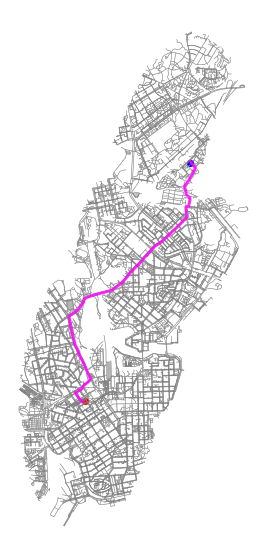

In [50]:
shortest_path_map(origin, destination, 'walk')
# plt.savefig('walking_network.png')

C:\Users\bryan\anaconda3\envs\dev\lib\site-packages\osmnx\distance.py:356: UserWarning: The `get_nearest_node` function has been deprecated and will be removed in a future release. Use the more efficient `distance.nearest_nodes` instead.
  warnings.warn(msg)


<AxesSubplot:>

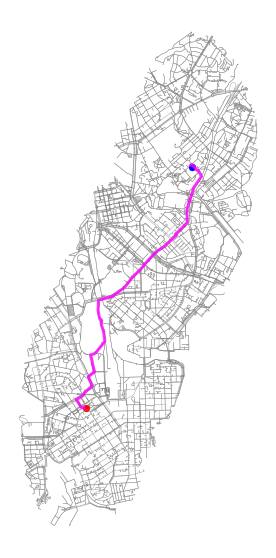

In [51]:
shortest_path_map(origin, destination, 'bike')
# plt.savefig('cycling_network.png')

C:\Users\bryan\anaconda3\envs\dev\lib\site-packages\osmnx\distance.py:356: UserWarning: The `get_nearest_node` function has been deprecated and will be removed in a future release. Use the more efficient `distance.nearest_nodes` instead.
  warnings.warn(msg)


<AxesSubplot:>

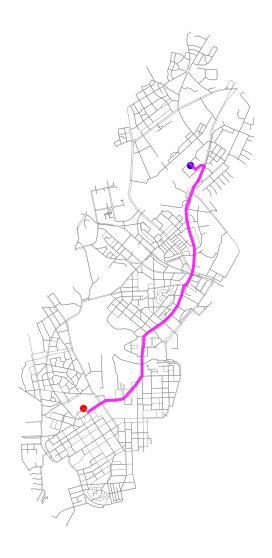

In [52]:
shortest_path_map(origin, destination)
# plt.savefig('driving_network.png')